# LSA Cluster Visualization

This jupyter notebook generates publication-grade visualizations for the LSA + K-Means clustering pipeline. Core outputs include a Comprehensive Analysis Dashboard that leverages UMAP/t-SNE projections to reveal latent semantic structures , alongside long-tail cluster size distributions and cumulative coverage curves. It provides deep diagnostic capabilities through a Quality Heatmap, which evaluates top clusters across internal coherence, separation, and density, and an Advanced Silhouette Analysis that renders individual cluster profiles to detect boundary ambiguity.

In [ ]:


import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import font_manager
from pathlib import Path
from collections import Counter
from typing import Dict, List, Tuple, Optional
import warnings
import sys

warnings.filterwarnings("ignore")

import seaborn as sns
import pandas as pd


try:
    REPO_ROOT = Path(__file__).resolve().parents[2]
except NameError:
    # Jupyter Notebook fallback
    curr = Path('.').resolve()
    if (curr / 'data').exists():
        REPO_ROOT = curr
    elif (curr.parent / 'data').exists():
        REPO_ROOT = curr.parent
    elif (curr.parents[1] / 'data').exists():
        REPO_ROOT = curr.parents[1]
    else:
        REPO_ROOT = curr # Fallback
DATA_DIR = REPO_ROOT / "data"
LSA_DIR = DATA_DIR / "lsa"
TFIDF_DIR = DATA_DIR / "tf_idf"
METRICS_DIR = DATA_DIR / "metrics"

VIZ_OUT_DIR = LSA_DIR / "visualizations" / "paper_quality"
VIZ_OUT_DIR.mkdir(parents=True, exist_ok=True)

LSA_REDUCED_PATH = LSA_DIR / "lsa_reduced.npz"
CLUSTER_LABELS_PATH = LSA_DIR / "cluster_labels.npy"
DOC_IDS_PATH = TFIDF_DIR / "doc_ids.npy"
DOC_TITLES_PATH = TFIDF_DIR / "doc_titles.npy"
CLUSTER_KEYWORDS_PATH = LSA_DIR / "cluster_analysis" / "cluster_keywords.json"
METRICS_PATH = METRICS_DIR / "kmeans_lsa_metrics.json"

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'text.usetex': False,
})

COLORS = {
    'primary': '#2c3e50',      
    'secondary': '#3498db',    
    'accent': '#e74c3c',       
    'success': '#27ae60',      
    'warning': '#f39c12',      
    'info': '#3498db',         
    'cluster_palette': 'tab20',
}

sns.set_style("whitegrid", {
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})


def load_data():
    print("[i] Loading LSA data...")
    
    if not LSA_REDUCED_PATH.exists():
        raise FileNotFoundError(f"LSA file not found: {LSA_REDUCED_PATH}")
    with np.load(LSA_REDUCED_PATH) as data:
        embeddings = data['X_reduced']
    
    if not CLUSTER_LABELS_PATH.exists():
        raise FileNotFoundError(f"Labels file not found: {CLUSTER_LABELS_PATH}")
    labels = np.load(CLUSTER_LABELS_PATH)
    
    doc_ids = np.load(DOC_IDS_PATH) if DOC_IDS_PATH.exists() else None
    doc_titles = np.load(DOC_TITLES_PATH) if DOC_TITLES_PATH.exists() else None
    
    # 4. Load Metrics
    metrics = {}
    if METRICS_PATH.exists():
        with METRICS_PATH.open("r", encoding="utf-8") as f:
            metrics = json.load(f)
    else:
        print(f"[warn] Metrics file not found: {METRICS_PATH}")
        metrics = {'n_clusters': len(np.unique(labels)), 'n_samples': len(labels)}

    # 5. Load Keywords
    cluster_top_terms = {}
    if CLUSTER_KEYWORDS_PATH.exists():
        with CLUSTER_KEYWORDS_PATH.open("r", encoding="utf-8") as f:
            content = f.read().strip()
            if content.startswith('['):
                    keywords_data = json.loads(content)
                    for item in keywords_data:
                        cluster_top_terms[str(item['cluster'])] = item['keywords']
            else:
                lines = content.split('\n')
                for line in lines:
                    if line.strip():
                        item = json.loads(line)
                        cluster_top_terms[str(item['cluster'])] = item['keywords']
    
    print(f"[i] Loaded {len(labels)} documents, {len(embeddings)} embeddings")
    print(f"[i] Number of clusters: {len(np.unique(labels))}")
    
    return embeddings, labels, doc_ids, doc_titles, metrics, cluster_top_terms


def calculate_cluster_statistics(embeddings: np.ndarray, labels: np.ndarray) -> Dict:
    clustered_mask = labels != -1 
    X_clustered = embeddings[clustered_mask]
    labels_clustered = labels[clustered_mask]
    
    unique_labels = np.unique(labels_clustered)
    stats = {
        'cluster_internal_coherence': {},
        'cluster_separation': {},
        'cluster_density': {},
        'cluster_compactness': {},
    }
    
    from sklearn.metrics.pairwise import euclidean_distances
    
   
    if len(X_clustered) > 20000:
        indices = np.random.choice(len(X_clustered), size=20000, replace=False)
        X_calc = X_clustered[indices]
        labels_calc = labels_clustered[indices]
    else:
        X_calc = X_clustered
        labels_calc = labels_clustered
        
    unique_labels_calc = np.unique(labels_calc)

    for label in unique_labels_calc:
        mask = labels_calc == label
        cluster_points = X_calc[mask]
        centroid = cluster_points.mean(axis=0)
        
        distances_to_centroid = np.linalg.norm(cluster_points - centroid, axis=1)
        stats['cluster_internal_coherence'][label] = float(distances_to_centroid.mean())
        
        if len(cluster_points) > 1:
            radius = distances_to_centroid.max()
            stats['cluster_density'][label] = float(len(cluster_points) / (radius + 1e-10))
        else:
            stats['cluster_density'][label] = 0.0
        
        stats['cluster_compactness'][label] = float(distances_to_centroid.std())
    
    centroids = {}
    for label in unique_labels_calc:
        mask = labels_calc == label
        centroids[label] = X_calc[mask].mean(axis=0)
    
    if len(centroids) > 0:
        centroid_array = np.array([centroids[label] for label in unique_labels_calc])
        inter_cluster_distances = euclidean_distances(centroid_array)
        np.fill_diagonal(inter_cluster_distances, np.inf)
        
        for i, label in enumerate(unique_labels_calc):
            stats['cluster_separation'][label] = float(inter_cluster_distances[i].min())
    
    return stats





In [2]:
print("=" * 70)
print("LSA Paper-Quality Visualization")
print("=" * 70)

embeddings, labels, doc_ids, doc_titles, metrics, cluster_top_terms = load_data()

# Load SBERT metrics for comparison
sbert_metrics_path = DATA_DIR / "sbert_hdbscan_test" / "hdbscan_metrics.json"
metrics_sbert = None
if sbert_metrics_path.exists():
    with sbert_metrics_path.open("r", encoding="utf-8") as f:
        metrics_sbert = json.load(f)



LSA Paper-Quality Visualization
[i] Loading LSA data...


[i] Loaded 732367 documents, 732367 embeddings
[i] Number of clusters: 40


[i] Creating comprehensive clustering analysis figure...
[i] Saved: /work3/s242644/ds/PaperTrail/data/lsa/visualizations/paper_quality/comprehensive_clustering_analysis.png


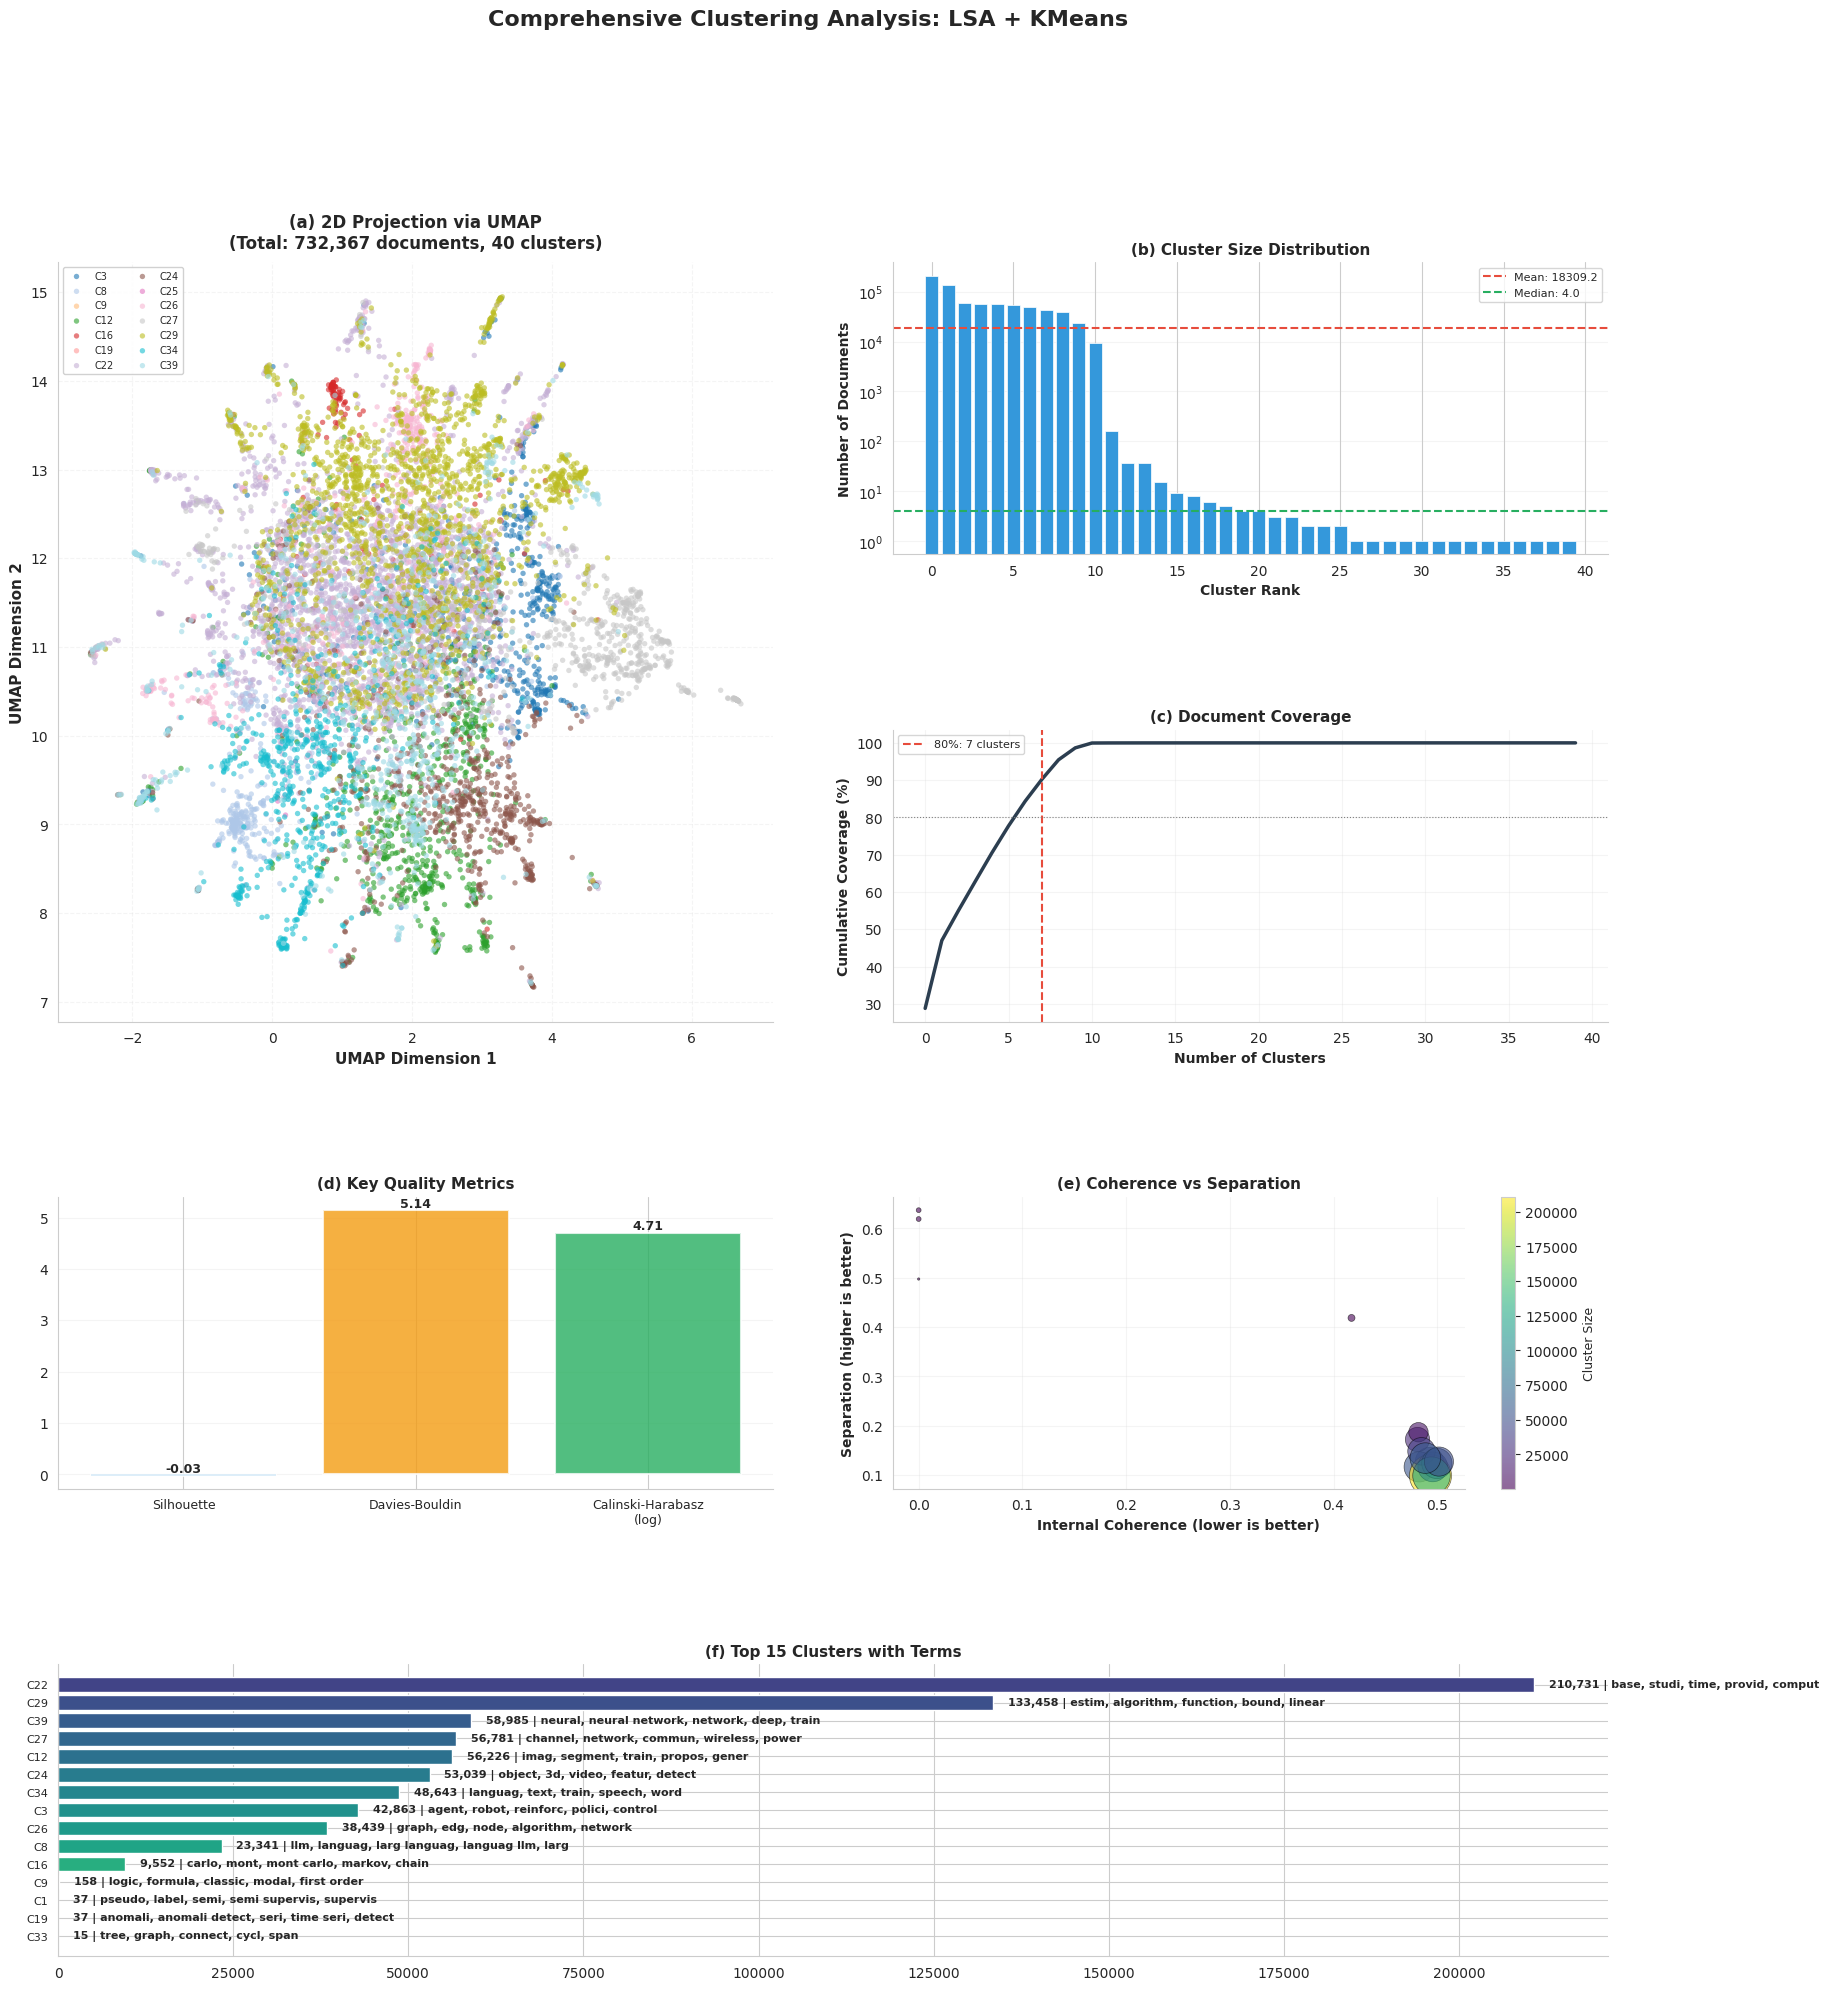

In [ ]:

def plot_comprehensive_clustering_analysis(embeddings: np.ndarray, labels: np.ndarray, 
                                         metrics: Dict, cluster_top_terms: Dict):
    print("[i] Creating comprehensive clustering analysis figure...")
    
    cluster_stats = calculate_cluster_statistics(embeddings, labels)
    
    sample_size = min(10000, len(embeddings))
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), size=sample_size, replace=False)
        X_sample = embeddings[indices]
        labels_sample = labels[indices]
    else:
        X_sample = embeddings
        labels_sample = labels
    
    try:
        import umap
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        X_2d = reducer.fit_transform(X_sample)
        method_name = "UMAP"
    except ImportError:
        from sklearn.manifold import TSNE
        X_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sample)
        method_name = "t-SNE"
    
    fig = plt.figure(figsize=(20, 22))
    gs = fig.add_gridspec(4, 4, hspace=0.6, wspace=0.4)
    
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    unique_labels = np.unique(labels_sample)
    
    if len(unique_labels) > 0:
        colors = plt.cm.tab20(np.linspace(0, 1, min(len(unique_labels), 20)))
        for i, label in enumerate(unique_labels[:20]):
            mask = labels_sample == label
            size = mask.sum()
            ax1.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                       c=[colors[i]], s=15, alpha=0.6, 
                       label=f'C{label}' if size < 1000 else f'C{label}',
                       rasterized=True, edgecolors='none')
            
    ax1.set_xlabel(f'{method_name} Dimension 1', fontsize=11, fontweight='bold')
    ax1.set_ylabel(f'{method_name} Dimension 2', fontsize=11, fontweight='bold')
    ax1.set_title(f'(a) 2D Projection via {method_name}\n'
                  f'(Total: {len(labels):,} documents, '
                  f'{metrics.get("n_clusters", len(unique_labels))} clusters)', 
                  fontsize=12, fontweight='bold', pad=10)
    # Legend handling for too many clusters
    if len(unique_labels) <= 20:
        ax1.legend(loc='upper left', fontsize=7, framealpha=0.9, ncol=2)
    ax1.grid(True, alpha=0.2, linestyle='--')
    
    ax2 = fig.add_subplot(gs[0, 2:4])
    unique_labels_all, counts_all = np.unique(labels, return_counts=True)
    sorted_counts = sorted(counts_all, reverse=True)
    
    ax2.bar(range(len(sorted_counts)), sorted_counts, 
                   color=COLORS['secondary'], edgecolor='white', linewidth=0.5)
    
    mean_size = np.mean(sorted_counts)
    median_size = np.median(sorted_counts)
    ax2.axhline(y=mean_size, color=COLORS['accent'], linestyle='--', 
                linewidth=1.5, label=f'Mean: {mean_size:.1f}')
    ax2.axhline(y=median_size, color=COLORS['success'], linestyle='--', 
                linewidth=1.5, label=f'Median: {median_size:.1f}')
    
    ax2.set_xlabel('Cluster Rank', fontsize=10, fontweight='bold')
    ax2.set_ylabel('Number of Documents', fontsize=10, fontweight='bold')
    ax2.set_title(f'(b) Cluster Size Distribution', fontsize=11, fontweight='bold')
    ax2.set_yscale('log')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.2, axis='y')
    
    ax3 = fig.add_subplot(gs[1, 2:4])
    cumulative_coverage = np.cumsum(sorted_counts) / sum(sorted_counts)
    
    coverage_80_idx = np.where(cumulative_coverage >= 0.8)[0]
    coverage_80_num = coverage_80_idx[0] + 1 if len(coverage_80_idx) > 0 else len(cumulative_coverage)
    
    ax3.plot(range(len(cumulative_coverage)), cumulative_coverage * 100, 
            linewidth=2.5, color=COLORS['primary'])
    
    ax3.axvline(x=coverage_80_num, color=COLORS['accent'], linestyle='--', 
               linewidth=1.5, label=f'80%: {coverage_80_num} clusters')
    ax3.axhline(y=80, color='gray', linestyle=':', linewidth=0.8)
    
    ax3.set_xlabel('Number of Clusters', fontsize=10, fontweight='bold')
    ax3.set_ylabel('Cumulative Coverage (%)', fontsize=10, fontweight='bold')
    ax3.set_title('(c) Document Coverage', fontsize=11, fontweight='bold')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.2)
    
    ax4 = fig.add_subplot(gs[2, 0:2])
    
    metrics_to_plot = {
        'Silhouette': metrics.get('Silhouette', 0),
        'Davies-Bouldin': metrics.get('DBI', 0) if metrics.get('DBI') else 0,
        'Calinski-Harabasz\n(log)': np.log1p(metrics.get('CH', 0)),
    }
    
    # Normalize simply for display
    max_val = max(abs(v) for v in metrics_to_plot.values()) if metrics_to_plot else 1
    
    x_pos = np.arange(len(metrics_to_plot))
    bars = ax4.bar(x_pos, list(metrics_to_plot.values()), 
                   color=[COLORS['secondary'], COLORS['warning'], COLORS['success']],
                   edgecolor='white', linewidth=1.5, alpha=0.8)
    
    for i, (bar, (key, val)) in enumerate(zip(bars, metrics_to_plot.items())):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(list(metrics_to_plot.keys()), fontsize=9)
    ax4.set_title('(d) Key Quality Metrics', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.2, axis='y')
    
    ax5 = fig.add_subplot(gs[2, 2:4])
    
    coherence_values = []
    separation_values = []
    cluster_sizes = []
    
    for label in unique_labels_all:
        if label in cluster_stats['cluster_internal_coherence']:
            coherence_values.append(cluster_stats['cluster_internal_coherence'][label])
            separation_values.append(cluster_stats['cluster_separation'].get(label, 0))
            cluster_sizes.append(counts_all[unique_labels_all == label][0])
    
    scatter = ax5.scatter(coherence_values, separation_values, 
                         s=[np.sqrt(s)*2 for s in cluster_sizes], 
                         c=cluster_sizes, cmap='viridis', 
                         alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax5.set_xlabel('Internal Coherence (lower is better)', fontsize=10, fontweight='bold')
    ax5.set_ylabel('Separation (higher is better)', fontsize=10, fontweight='bold')
    ax5.set_title('(e) Coherence vs Separation', fontsize=11, fontweight='bold')
    
    cbar = plt.colorbar(scatter, ax=ax5)
    cbar.set_label('Cluster Size', fontsize=9)
    ax5.grid(True, alpha=0.2)
    
    ax6 = fig.add_subplot(gs[3, 0:4])
    
    label_to_count = dict(zip(unique_labels_all, counts_all))
    sorted_clusters = sorted(label_to_count.items(), key=lambda x: x[1], reverse=True)[:15]
    
    cluster_ids = [str(cid) for cid, _ in sorted_clusters]
    cluster_sizes_plot = [size for _, size in sorted_clusters]
    
    top_terms_display = []
    for cid in cluster_ids:
        if cid in cluster_top_terms:
            terms = cluster_top_terms[cid][:5]
            top_terms_display.append(', '.join([t[:15] for t in terms]))
        else:
            top_terms_display.append("No terms")
    
    y_pos = np.arange(len(cluster_ids))
    bars = ax6.barh(y_pos, cluster_sizes_plot, 
                    color=plt.cm.viridis(np.linspace(0.2, 0.8, len(cluster_ids))),
                    edgecolor='white', linewidth=1)
    
    for i, (bar, size, terms) in enumerate(zip(bars, cluster_sizes_plot, top_terms_display)):
        ax6.text(size + max(cluster_sizes_plot)*0.01, bar.get_y() + bar.get_height()/2,
                f'{size:,} | {terms}', 
                va='center', fontsize=8, fontweight='bold')
    
    ax6.set_yticks(y_pos)
    ax6.set_yticklabels([f'C{cid}' for cid in cluster_ids], fontsize=8)
    ax6.set_title('(f) Top 15 Clusters with Terms', fontsize=11, fontweight='bold')
    ax6.invert_yaxis()
    
    fig.suptitle('Comprehensive Clustering Analysis: LSA + KMeans', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    save_path = VIZ_OUT_DIR / "comprehensive_clustering_analysis.png"
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {save_path}")
    plt.show()


plot_comprehensive_clustering_analysis(embeddings, labels, metrics, cluster_top_terms)


[i] Creating cluster quality heatmap...
[i] Saved: /work3/s242644/ds/PaperTrail/data/lsa/visualizations/paper_quality/cluster_quality_heatmap.png


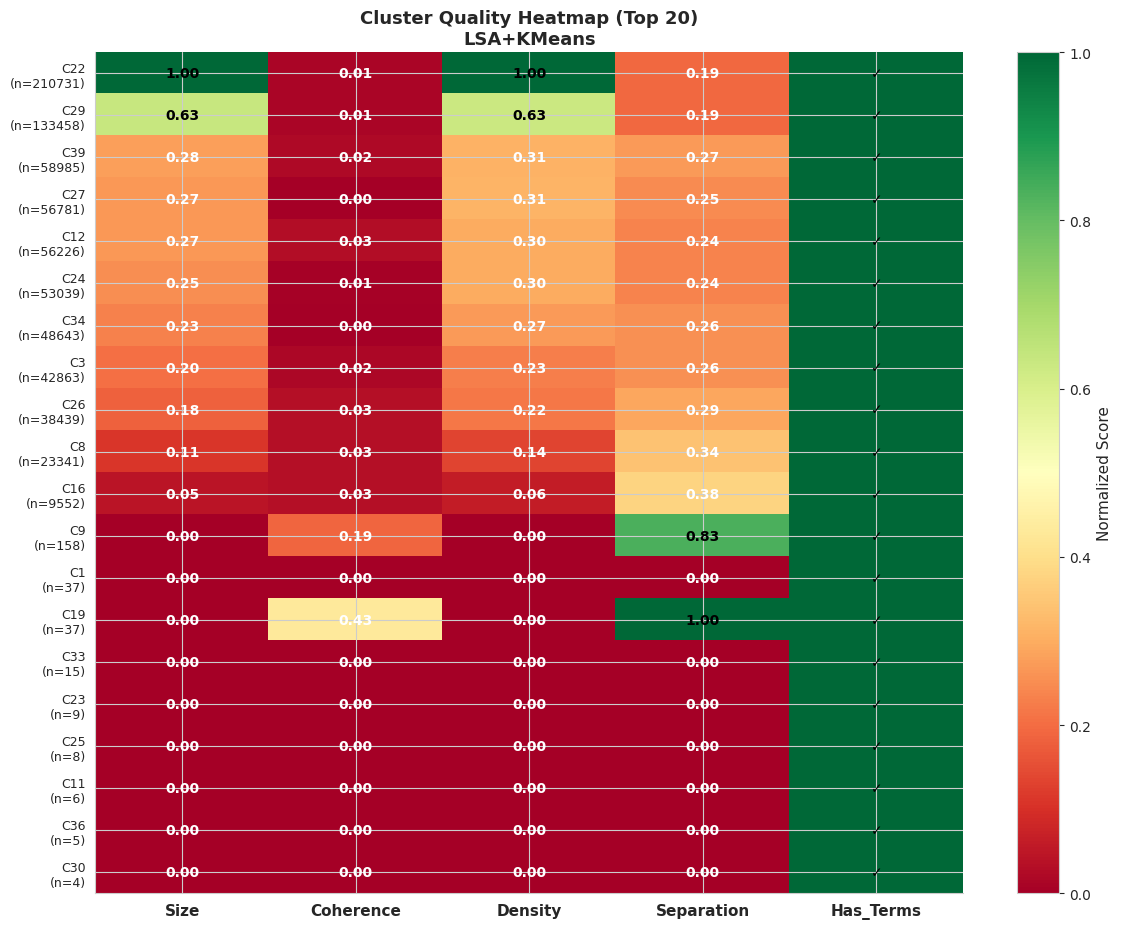

In [ ]:

def plot_cluster_quality_heatmap(embeddings: np.ndarray, labels: np.ndarray, 
                                 cluster_top_terms: Dict, top_n: int = 20):
    print("[i] Creating cluster quality heatmap...")
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_to_count = dict(zip(unique_labels, counts))
    
    sorted_clusters = sorted(label_to_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
    selected_labels = [label for label, _ in sorted_clusters]
    
    metric_names = ['Size', 'Coherence', 'Density', 'Separation', 'Has_Terms']
    cluster_stats = calculate_cluster_statistics(embeddings, labels)
    
    quality_matrix = []
    
    for label in selected_labels:
        row = []
        # Size
        row.append(label_to_count[label] / max(counts))
        
        # Coherence (normalized, smaller is better so invert)
        if label in cluster_stats['cluster_internal_coherence']:
            max_coherence = max(cluster_stats['cluster_internal_coherence'].values())
            row.append(1 - cluster_stats['cluster_internal_coherence'][label] / (max_coherence + 1e-10))
        else:
            row.append(0)
            
        # Density
        if label in cluster_stats['cluster_density']:
            max_density = max([v for v in cluster_stats['cluster_density'].values() if v > 0] or [1])
            row.append(cluster_stats['cluster_density'][label] / max_density)
        else:
            row.append(0)
            
        # Separation
        if label in cluster_stats['cluster_separation']:
            max_sep = max(cluster_stats['cluster_separation'].values())
            row.append(cluster_stats['cluster_separation'][label] / (max_sep + 1e-10))
        else:
            row.append(0)
            
        # Has Terms
        row.append(1.0 if str(label) in cluster_top_terms else 0.0)
        
        quality_matrix.append(row)
        
    quality_matrix = np.array(quality_matrix)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(quality_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    cluster_labels_display = [f'C{label}\n(n={label_to_count[label]})' for label in selected_labels]
    ax.set_xticks(np.arange(len(metric_names)))
    ax.set_yticks(np.arange(len(selected_labels)))
    ax.set_xticklabels(metric_names, fontsize=11, fontweight='bold')
    ax.set_yticklabels(cluster_labels_display, fontsize=9)
    
    for i in range(len(selected_labels)):
        for j in range(len(metric_names)):
            val = quality_matrix[i, j]
            text_color = 'white' if val < 0.5 else 'black'
            text = f'{val:.2f}' if metric_names[j] != 'Has_Terms' else ('✓' if val > 0.5 else '✗')
            ax.text(j, i, text, ha="center", va="center", color=text_color, fontweight='bold')
            
    ax.set_title(f'Cluster Quality Heatmap (Top {top_n})\nLSA+KMeans', fontsize=13, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Normalized Score', fontsize=11)
    
    plt.tight_layout()
    save_path = VIZ_OUT_DIR / "cluster_quality_heatmap.png"
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {save_path}")
    plt.show()





plot_cluster_quality_heatmap(embeddings, labels, cluster_top_terms)


[i] Creating advanced silhouette analysis...
[i] Saved: /work3/s242644/ds/PaperTrail/data/lsa/visualizations/paper_quality/advanced_silhouette_analysis.png


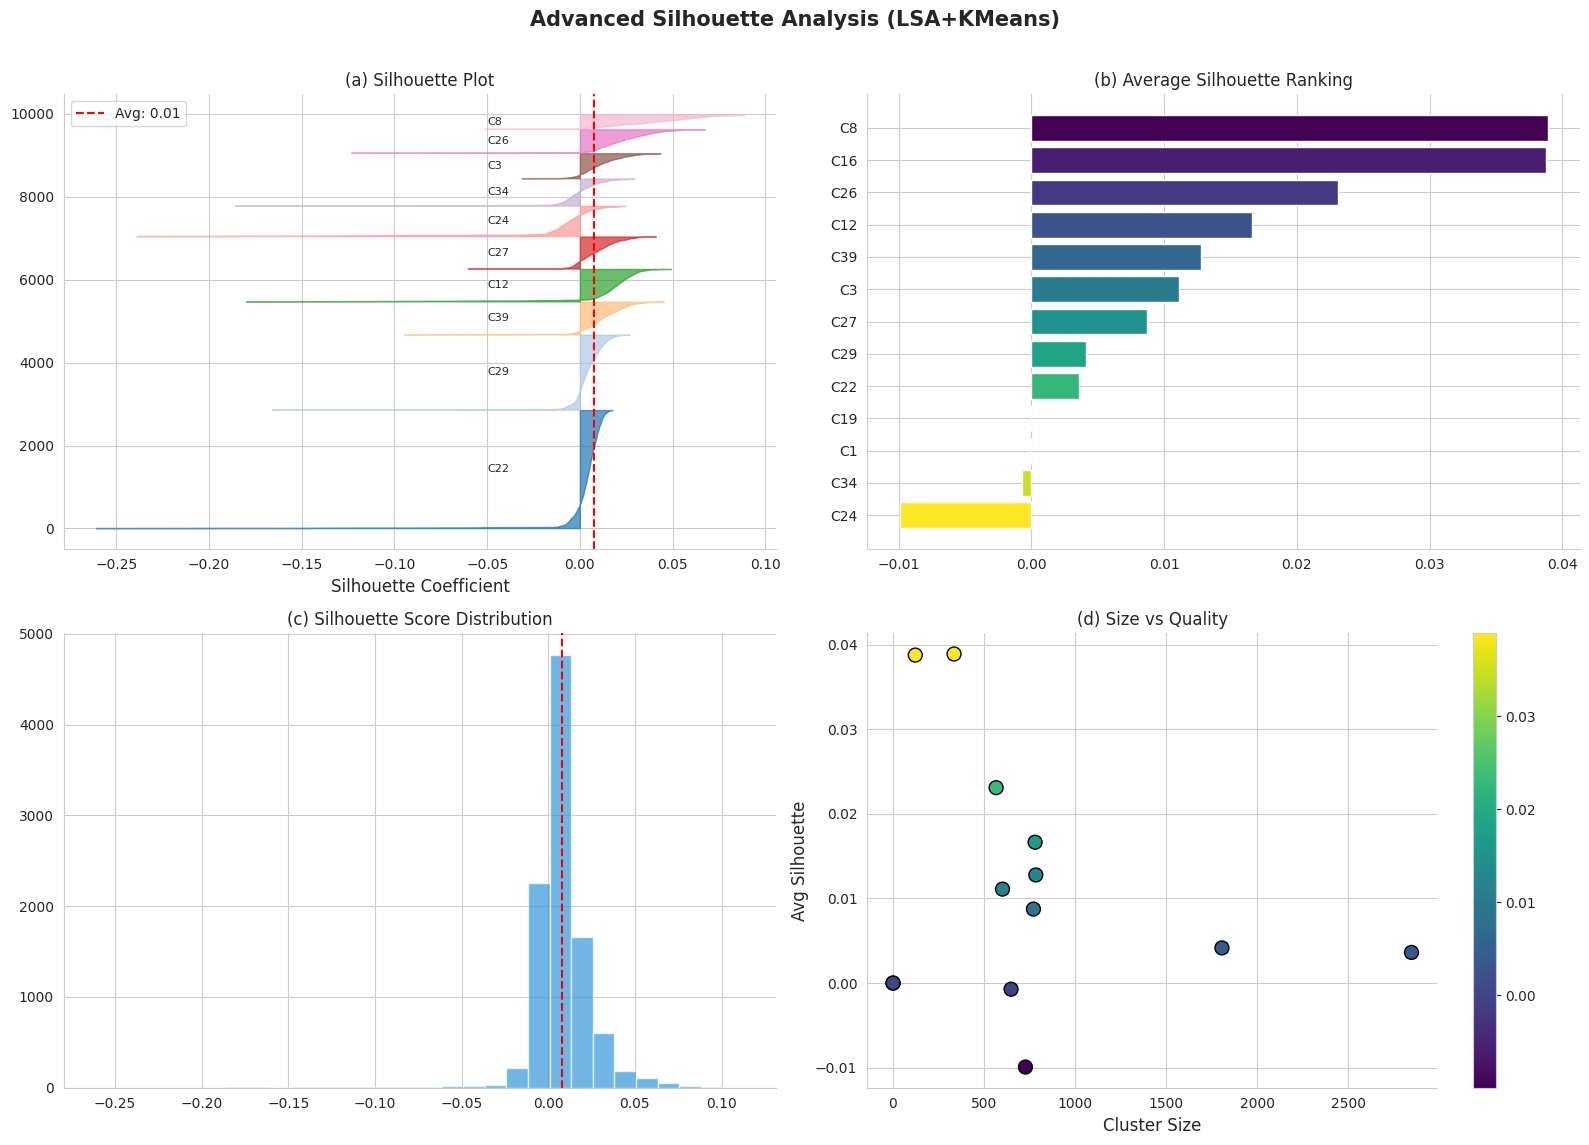

In [ ]:


def plot_advanced_silhouette_analysis(embeddings: np.ndarray, labels: np.ndarray, top_clusters: int = 15):
    print("[i] Creating advanced silhouette analysis...")
    
    sample_size = min(10000, len(embeddings))
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), size=sample_size, replace=False)
        X_sample = embeddings[indices]
        labels_sample = labels[indices]
    else:
        X_sample = embeddings
        labels_sample = labels
        
    from sklearn.metrics import silhouette_samples, silhouette_score
    
    silhouette_vals = silhouette_samples(X_sample, labels_sample, metric='euclidean')
    avg_score = silhouette_score(X_sample, labels_sample, metric='euclidean')
    
    label_counts = Counter(labels_sample)
    top_labels = [l for l, _ in label_counts.most_common(top_clusters)]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Advanced Silhouette Analysis (LSA+KMeans)', fontsize=15, fontweight='bold')
    
    # 1. Silhouette Plot
    ax1 = axes[0, 0]
    y_lower = 10
    for i, label in enumerate(top_labels[:10]):
        mask = labels_sample == label
        ith_vals = silhouette_vals[mask]
        ith_vals.sort()
        size = ith_vals.shape[0]
        y_upper = y_lower + size
        
        color = plt.cm.tab20(i / len(top_labels))
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals, 
                            facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size, f'C{label}', fontsize=8, va='center')
        y_lower = y_upper + 10
        
    ax1.axvline(x=avg_score, color="red", linestyle="--", label=f'Avg: {avg_score:.2f}')
    ax1.set_title('(a) Silhouette Plot', fontsize=12)
    ax1.set_xlabel('Silhouette Coefficient')
    ax1.legend()
    
    # 2. Ranking
    ax2 = axes[0, 1]
    cluster_avg_sil = {}
    for label in top_labels:
        mask = labels_sample == label
        cluster_avg_sil[label] = silhouette_vals[mask].mean()
        
    sorted_sils = sorted(cluster_avg_sil.items(), key=lambda x: x[1], reverse=True)
    c_ids = [f'C{k}' for k, v in sorted_sils]
    c_vals = [v for k, v in sorted_sils]
    
    ax2.barh(range(len(c_ids)), c_vals, color=plt.cm.viridis(np.linspace(0, 1, len(c_ids))))
    ax2.set_yticks(range(len(c_ids)))
    ax2.set_yticklabels(c_ids)
    ax2.set_title('(b) Average Silhouette Ranking', fontsize=12)
    ax2.invert_yaxis()
    
    # 3. Distribution
    ax3 = axes[1, 0]
    ax3.hist(silhouette_vals, bins=30, color=COLORS['secondary'], alpha=0.7)
    ax3.axvline(x=avg_score, color='red', linestyle='--')
    ax3.set_title('(c) Silhouette Score Distribution', fontsize=12)
    
    # 4. Size vs Quality
    ax4 = axes[1, 1]
    sizes = [label_counts[l] for l in top_labels]
    sils = [cluster_avg_sil[l] for l in top_labels]
    
    scatter = ax4.scatter(sizes, sils, c=sils, cmap='viridis', s=100, edgecolors='black')
    ax4.set_xlabel('Cluster Size')
    ax4.set_ylabel('Avg Silhouette')
    ax4.set_title('(d) Size vs Quality', fontsize=12)
    plt.colorbar(scatter, ax=ax4)
    
    plt.tight_layout()
    save_path = VIZ_OUT_DIR / "advanced_silhouette_analysis.png"
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {save_path}")
    plt.show()



plot_advanced_silhouette_analysis(embeddings, labels)


[i] Creating detailed cluster topics visualization...
[i] Saved: /work3/s242644/ds/PaperTrail/data/lsa/visualizations/paper_quality/detailed_cluster_topics.png


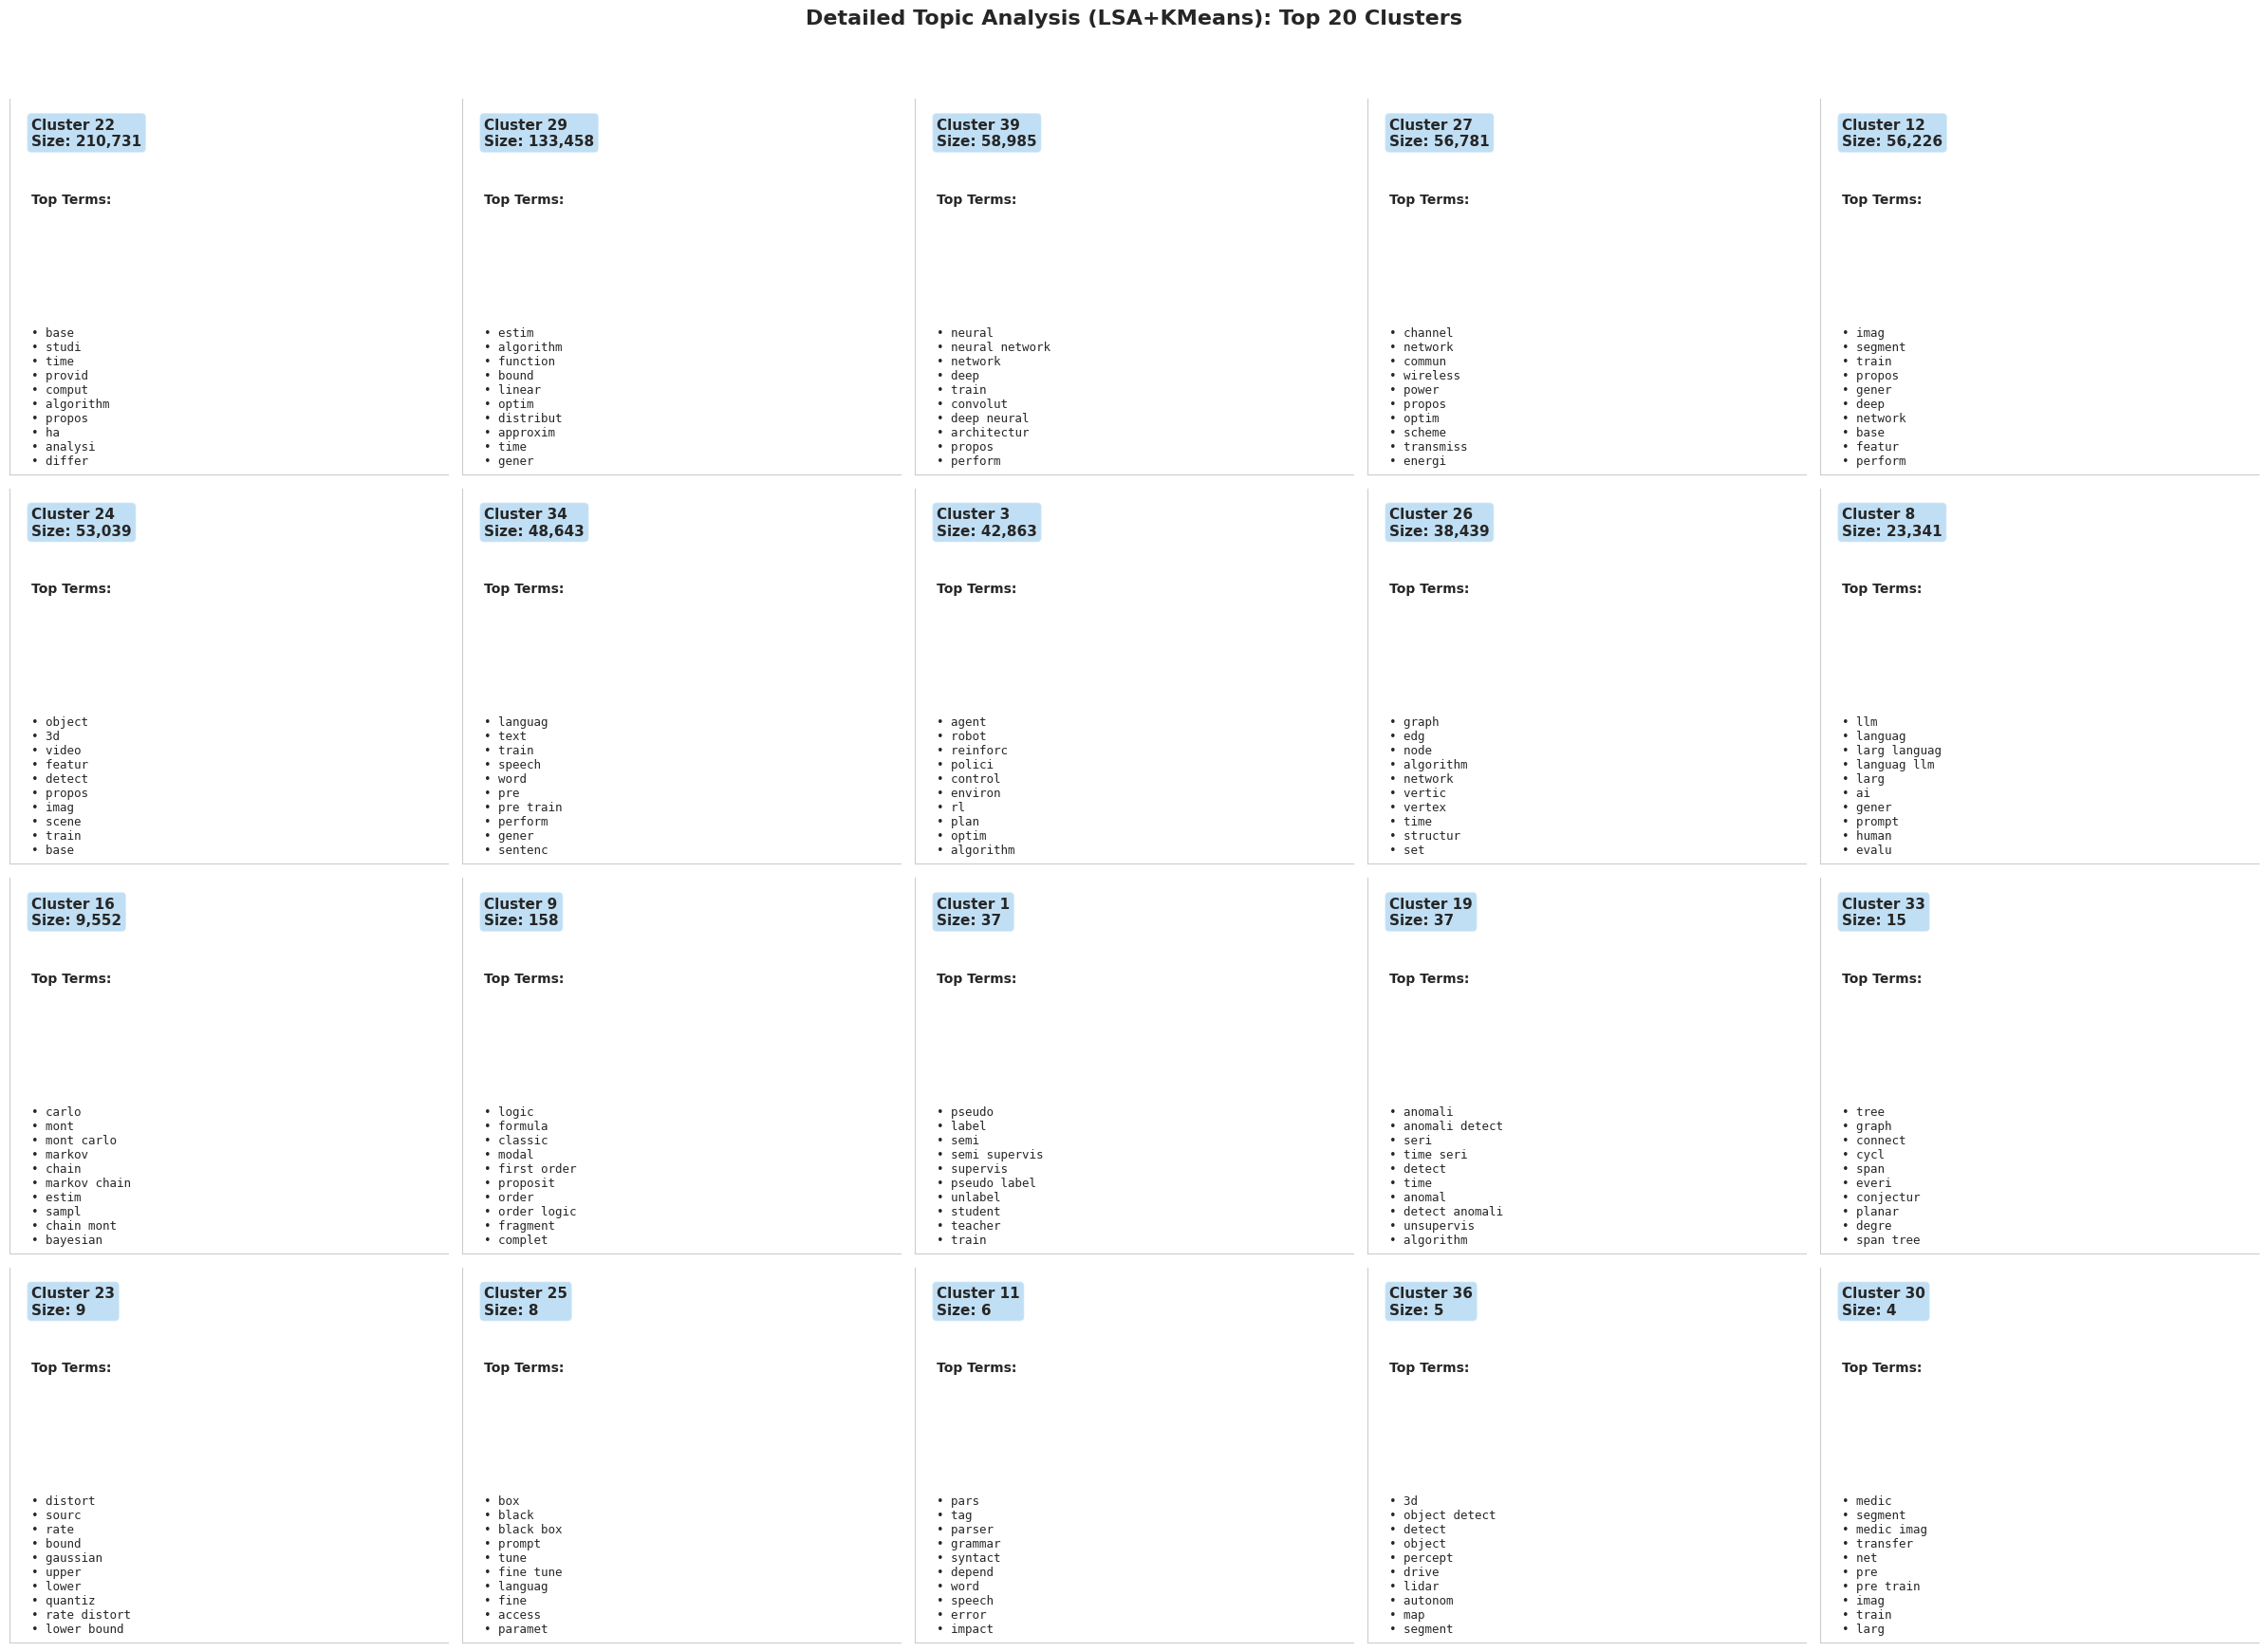

In [ ]:

def plot_cluster_topics_detailed(cluster_top_terms: Dict, labels: np.ndarray, top_n: int = 20):
    print("[i] Creating detailed cluster topics visualization...")
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_to_count = dict(zip(unique_labels, counts))
    sorted_clusters = sorted(label_to_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    fig, axes = plt.subplots(4, 5, figsize=(24, 18))
    fig.suptitle(f'Detailed Topic Analysis (LSA+KMeans): Top {top_n} Clusters', 
                 fontsize=16, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    for idx, (cluster_id, size) in enumerate(sorted_clusters):
        ax = axes[idx]
        cid_str = str(cluster_id)
        
        if cid_str in cluster_top_terms:
            terms = cluster_top_terms[cid_str][:10]
            terms_text = '\n'.join([f'• {term[:25]}' for term in terms])
        else:
            terms_text = "No terms extracted"
            
        ax.text(0.05, 0.95, f'Cluster {cluster_id}\nSize: {size:,}', 
               transform=ax.transAxes, fontsize=11, fontweight='bold',
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor=COLORS['secondary'], alpha=0.3))
        
        ax.text(0.05, 0.75, 'Top Terms:', transform=ax.transAxes, fontsize=10, fontweight='bold', verticalalignment='top')
        ax.text(0.05, 0.02, terms_text, transform=ax.transAxes, fontsize=9, verticalalignment='bottom', family='monospace')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    for idx in range(len(sorted_clusters), len(axes)):
        axes[idx].axis('off')
        
    plt.tight_layout()
    save_path = VIZ_OUT_DIR / "detailed_cluster_topics.png"
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[i] Saved: {save_path}")
    plt.show() 



plot_cluster_topics_detailed(cluster_top_terms, labels)

